In [21]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from typing import List, Tuple
from torch import Tensor
import random
from copy import deepcopy

In [22]:
def load_data(
        n_samples_per_digit: int,
        root: str = "../../data/mnist"):
    """
    loads MNIST for meta learning with reptile.

    consider 'classify <digit1> vs <digit2>' as one reptile task
    -> save instances of digits in buckets

    :param n_samples_per_digit: number of samples per digit to decrease training time

    :return: out[<train or test>(0,1), <digit>(0,...,9), <data or target>(0,1), batch_dim]
    """
    mnist_train = MNIST(root=root, train=True, download=True)
    mnist_test = MNIST(root=root, train=False, download=True)

    subsets_train = []
    subsets_test = []

    sets = [mnist_train, mnist_test]
    subsets = [subsets_train, subsets_test]
    for digit in range(10):
        for i in range(2):
            cond = sets[i].targets == digit
            data = sets[i].data[cond][:n_samples_per_digit].unsqueeze(1).float()
            targets = sets[i].targets[cond][:n_samples_per_digit].long()
            subsets[i].append([data, targets])
    return subsets


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Dropout(p=0.1),  # data augmentation
            nn.Conv2d(
                in_channels=1,
                out_channels=3,
                kernel_size=3,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.1),  # implicit ensemble
            nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=3,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(
                in_channels=8,
                out_channels=10,
                kernel_size=7),  # learned global pool
            nn.Flatten())
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x: Tensor, y: Tensor):
        scores = self.layers(x)
        loss = self.loss(scores, y)
        return {"loss": loss, "scores": scores}


def accuracy(scores: Tensor, target: Tensor) -> float:
    preds = torch.argmax(scores, dim=1)
    return ((preds == target).sum() / len(target)).item()

In [23]:
def shuffle(x: Tensor, y: Tensor) -> Tuple[Tensor, Tensor]:
    """
    equally shuffle x and y in batch dimension
    """
    perm = torch.randperm(x.size(0))
    return x[perm], y[perm]


def sample_task(task_parts: List[int]) -> Tuple[int, int]:
    """
    samples two digits that have to be distinguished by the model

    :param task_parts: task parts considered in reptile,
    task_parts=[1, 2, 3] only allows "classify 1 vs 2", "classify 1 vs 3", "classify 2 vs 3"

    :param banned_task: task that is banned
    task_parts=[1, 2, 3], banned_task=(1, 2) only allows "classify 1 vs 3", "classify 2 vs 3"
    """
    while True:
        digit1 = random.randint(a=0, b=9)
        digit2 = random.randint(a=0, b=9)
        if digit1 in task_parts:
            if digit2 in task_parts:
                if digit1 != digit2:
                    return digit1, digit2


def reptile_sgd(
        n_iters_outer: int,
        n_iters_inner: int,
        meta_batch_size: int,
        classifier: Classifier,
        lr_inner: float,
        lr_outer: float,
        task_parts_group_1: List[int],
        task_parts_group_2: List[int],
        data_test: Tuple[Tensor, Tensor],
        data_train: Tuple[Tensor, Tensor]):
    """
    performs batched reptile.
    in each outer iteration, a batch of tasks is drawn.
    for each task, a copy of the meta model is trained.
    meta model is updated with the average update over all task-specifically trained copies.

    is sequential reptile for meta_batch_size = 1

    for this experiment:
    <classify x vs y> AND <classify y vs z> would infer <classify x vs z> ("task-transitivity")
    -> tasks are grouped into two groups, so that tasks exists that can't be inferred through "task-transitivity"
    """

    task_parts = [task_parts_group_1, task_parts_group_2]
    classifier.train()
    learned_tasks = []
    losses_train = []
    accs_train = []
    losses_test = []
    accs_test = []
    num_task_parts = len(data_train)
    eval_data_train = torch.cat([data_train[task_id][0] for task_id in range(num_task_parts)])
    eval_target_train = torch.cat([data_train[task_id][1] for task_id in range(num_task_parts)])

    eval_data_test = torch.cat([data_test[task_id][0] for task_id in range(num_task_parts)])
    eval_target_test = torch.cat([data_test[task_id][1] for task_id in range(num_task_parts)])

    for i in range(n_iters_outer):
        if (i + 1) % 50 == 0:
            print("iteration", i + 1)

        classifiers_meta_batch = []
        for _ in range(meta_batch_size):
            classifier_inner = deepcopy(classifier)
            # sample a task, e.g. 'classify 1 vs 3', select data accordingly
            task_parts_group = task_parts[torch.randint(low=0, high=1, size=(1,)).item()]
            task_part1, task_part2 = sample_task(task_parts=task_parts_group)
            learned_tasks.append(set((task_part1, task_part2)))
            data = torch.cat([data_train[task_part1][0], data_train[task_part2][0]])
            target = torch.cat([data_train[task_part1][1], data_train[task_part2][1]])
            data, target = shuffle(x=data, y=target)

            # train inner model on sampled task for n_iters_inner iterations
            for _ in range(n_iters_inner):
                classifier_inner.zero_grad()
                loss = classifier_inner(x=data, y=target)["loss"]
                for param in classifier_inner.parameters():
                    grad = torch.autograd.grad(loss, param, create_graph=True)[0]
                    param.data.sub_(lr_inner * grad)
            classifiers_meta_batch.append(classifier_inner)

        # get average parameter updates along meta batch
        params_inner = []
        for param in classifier.parameters():
            params_inner.append(torch.zeros_like(param))
        for cls in classifiers_meta_batch:
            for i, param in enumerate(cls.parameters()):
                params_inner[i] += (param / meta_batch_size)

        # update meta model parameters w:
        # w_outer := w_outer + lr_outer * (w_inner - w_outer)
        # (w_inner - w_outer) could be treated as (reptile-) gradient in e.g. ADAM
        for j, param_outer in enumerate(classifier.parameters()):
            param_outer.data.add_(lr_outer * (params_inner[j] - param_outer))

        # evaluation across all tasks
        with torch.no_grad():
            eval_out_train = classifier(x=eval_data_train, y=eval_target_train)
            losses_train.append(eval_out_train["loss"].item())
            accs_train.append(accuracy(scores=eval_out_train["scores"], target=eval_target_train))

            eval_out_test = classifier(x=eval_data_test, y=eval_target_test)
            losses_test.append(eval_out_test["loss"].item())
            accs_test.append(accuracy(scores=eval_out_test["scores"], target=eval_target_test))
    return classifier, losses_train, losses_test, accs_train, accs_test, learned_tasks

In [24]:
def evaluate_few_shot(
        cls: Classifier,
        task_part1: int,
        task_part2: int,
        lr: float,
        data_train: List[Tuple[Tensor, Tensor]],
        data_test: List[Tuple[Tensor, Tensor]]):
    """
    evaluates the classifier cls on the task 'classify <task_part1> vs <task_part2>'
    without performing an update and after performing a single update
    """
    fs_data_train = torch.cat([data_train[task_part1][0], data_train[task_part2][0]])
    fs_target_train = torch.cat([data_train[task_part1][1], data_train[task_part2][1]])
    fs_data_train, fs_target_train = shuffle(x=fs_data_train, y=fs_target_train)

    fs_data_test = torch.cat([data_test[task_part1][0], data_test[task_part2][0]])
    fs_target_test = torch.cat([data_test[task_part1][1], data_test[task_part2][1]])
    fs_data_test, fs_target_test = shuffle(x=fs_data_test, y=fs_target_test)

    print("zero shot results:")
    cls.eval()
    with torch.no_grad():
        scores_train = cls(x=fs_data_train, y=fs_target_train)["scores"]
        scores_test = cls(x=fs_data_test, y=fs_target_test)["scores"]
        print("acc train:", accuracy(scores=scores_train, target=fs_target_train))
        print("acc test:", accuracy(scores=scores_test, target=fs_target_test))

    print("\nafter one training step:")
    cls.train()
    loss = cls(x=fs_data_train, y=fs_target_train)["loss"]
    for param in cls.parameters():
        grad = torch.autograd.grad(loss, param, create_graph=True)[0]
        param.data.sub_(lr * grad)

    cls.eval()
    with torch.no_grad():
        scores_train = cls(x=fs_data_train, y=fs_target_train)["scores"]
        scores_test = cls(x=fs_data_test, y=fs_target_test)["scores"]
        print("acc train:", accuracy(scores=scores_train, target=fs_target_train))
        print("acc test:", accuracy(scores=scores_test, target=fs_target_test))

# reptile training

In [31]:
n_samples_per_class = 10  # 10 works
n_iters_outer = 200  # 200 works
n_iters_inner = 5
data_train, data_test = load_data(n_samples_per_digit=n_samples_per_class)
reptile_task_parts_group_1 = [0, 1, 2, 3, 4]
reptile_task_parts_group_2 = [5, 6, 7, 8, 9]
lr_inner = 0.002
lr_outer = 0.001
meta_batch_size = 3

iteration 50
iteration 100
iteration 150
iteration 200


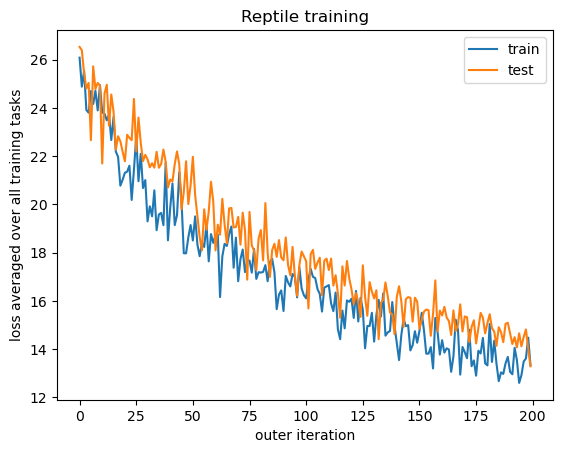

In [26]:
classifier = Classifier()
classifier_init = deepcopy(classifier)  # for baseline later on

classifier_pretrained, losses_train, losses_test, accs_train, accs_test, learned_tasks = reptile_sgd(
    n_iters_outer=n_iters_outer,
    n_iters_inner=n_iters_inner,
    meta_batch_size=meta_batch_size,
    classifier=classifier,
    data_train=data_train,
    data_test=data_test,
    task_parts_group_1=reptile_task_parts_group_1,
    task_parts_group_2=reptile_task_parts_group_2,
    lr_inner=lr_inner,
    lr_outer=lr_outer)

plt.plot(range(len(losses_train)), losses_train, label="train")
plt.plot(range(len(losses_test)), losses_test, label="test")
plt.xlabel("outer iteration")
plt.ylabel("loss averaged over all training tasks")
plt.title("Reptile training")
plt.legend()
plt.show()

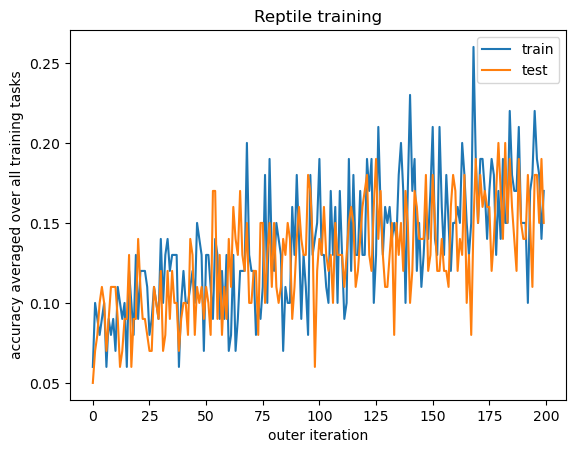

In [27]:
plt.plot(range(len(accs_train)), accs_train, label="train")
plt.plot(range(len(accs_test)), accs_test, label="test")
plt.xlabel("outer iteration")
plt.ylabel("accuracy averaged over all training tasks")
plt.title("Reptile training")
plt.legend()
plt.show()

# few shot evaluation

In [43]:
lr_fine_tune = lr_inner

print("tasks from same task group")
task1, task2 = (0, 1)
print(f"task '{task1} vs {task2}' was trained", learned_tasks.count(set((task1, task2))), "times in reptile")
evaluate_few_shot(
    cls=deepcopy(classifier_pretrained),
    task_part1=task1,
    task_part2=task2,
    data_train=data_train,
    data_test=data_test,
    lr=lr_fine_tune)

print("\n\ntasks from disjoint task groups")
task1, task2 = (0, 9)
print(f"task '{task1} vs {task2}' was trained", learned_tasks.count(set((task1, task2))), "times in reptile")
evaluate_few_shot(
    cls=deepcopy(classifier_pretrained),
    task_part1=task1,
    task_part2=task2,
    data_train=data_train,
    data_test=data_test,
    lr=lr_fine_tune)

print("\n\nbaseline")
evaluate_few_shot(
    cls=deepcopy(classifier_init),
    task_part1=task1,
    task_part2=task2,
    data_train=data_train,
    data_test=data_test,
    lr=lr_fine_tune)

tasks from same task group
task '0 vs 1' was trained 56 times in reptile
zero shot results:
acc train: 0.6000000238418579
acc test: 0.6499999761581421

after one training step:
acc train: 1.0
acc test: 1.0


tasks from disjoint task groups
task '0 vs 9' was trained 0 times in reptile
zero shot results:
acc train: 0.5
acc test: 0.4000000059604645

after one training step:
acc train: 0.75
acc test: 1.0


baseline
zero shot results:
acc train: 0.0
acc test: 0.0

after one training step:
acc train: 0.6000000238418579
acc test: 0.550000011920929




\begin{tabular}{ccc}
\text{without head replacement}& \text{seen task} & \text{new task} \\
\hline
\text{test accuracy one update after init} & & \bf{0.55} \\
\text{test accuracy after reptile} & 0.65 & 0.4 \\
\text{test accuracy one update after reptile} & 1 & \bf{1} \\
\end{tabular}

# conclusions
- zero shot results on a task and data used in reptile better than random
- reptile improves few shot results (55% accuracy without reptile pretraining, 100% with reptile pretraining)